In [9]:
import os
import torch

import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import time
import copy
import numpy as np
import random
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [10]:
from torch.optim import lr_scheduler
from torchvision import datasets
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, roc_curve
import logging

from pathlib import Path
from PIL import Image
import SimpleITK as sitk
from numpy import asarray
from math import sqrt
from scipy.special import ndtri
from numpy import argmax

In [12]:
class Medical_dataset(torch.utils.data.Dataset):

    def __init__(self, first_layer_files, second_layer_files, third_layer_files, labels, transforms):

        self.first_layer_files = first_layer_files
        self.second_layer_files = second_layer_files
        self.third_layer_files = third_layer_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return min(len(self.first_layer_files), len(self.second_layer_files), len(self.third_layer_files))
    
    def __getitem__(self, idx):

        # first layer will be mha files
        img_path = self.first_layer_files[idx]
        ds_A = sitk.ReadImage(img_path)
        img_A = sitk.GetArrayFromImage(ds_A)
        img_A = np.array(img_A, dtype=np.float32)
        min, max = np.min(img_A), np.max(img_A)
        img_A = ((img_A - min) / (max - min)) * 255
        PIL_image_A = Image.fromarray(img_A.astype(np.uint8))

        # second layer will be nii files
        img_path = self.second_layer_files[idx]
        ds_B = nib.load(img_path)
        img_B = np.array(ds_B.get_fdata(), dtype=np.float32)

        if len(img_B.shape) == 4:
            img_B = img_B[:,:,0,0]
        else:
            min, max = np.min(img_B), np.max(img_B)
            img_B = ((img_B - min) / (max - min)) * 255
            PIL_image_B = Image.fromarray(np.transpose(img_B).astype(np.uint8))

        # third layer will be nii files
        img_path = self.third_layer_files[idx]
        ds_C = nib.load(img_path)
        img_C = np.array(ds_C.get_fdata(), dtype=np.float32)

        if len(img_C.shape) == 4:
            img_C = img_C[:,:,0,0]
        else:
            min, max = np.min(img_C), np.max(img_C)
            img_C = ((img_C - min) / (max - min)) * 255
            PIL_image_C = Image.fromarray(np.transpose(img_C).astype(np.uint8))

        '''
        # get dcm files
        img_path_dcm = self.dcm_files[idx]
        ds_B = pydicom.read_file(img_path_dcm)
        img_B = np.array(ds_B.pixel_array, dtype=np.float32)

        min, max = np.min(img_B), np.max(img_B)
        img_B = 255 - ((img_B - min) / (max - min)) * 255
        PIL_image_dcm = Image.fromarray(img_B.astype(np.uint8))
        '''
        return self.transforms(PIL_image_A), self.transforms(PIL_image_B), self.transforms(PIL_image_C), self.labels[idx]

In [16]:
resol = 1024

train_transforms = transforms.Compose([
    transforms.Resize((resol, resol)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

valid_transforms = transforms.Compose([
    transforms.Resize((resol, resol)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# make dataset for train and valid based on class above
img_list = []
first_layer_files_list = []
fl_dir = '/data4/node21_dataset/cxr_images/original_data/images/' # len 4882
#fl_dir = '/data4/filtered_node21/' #len 4317
img_list = sorted(os.listdir(fl_dir))
files = sorted(os.listdir(fl_dir))
for file in files:
    first_layer_files_list.append(fl_dir + file)

second_layer_files_list = []
sl_dir = '/data4/tisepx_nodule/predict_lung/' # len 4318
files = sorted(os.listdir(sl_dir))
for file in files:
    second_layer_files_list.append(sl_dir + file)

third_layer_files_list = []
tl_dir = '/data4/tisepx_nodule/predict_pulmonaryLung/' # len 4318
files = sorted(os.listdir(tl_dir))
for file in files:
    third_layer_files_list.append(tl_dir + file)

labels = []
metadata_dir = '/data4/node21_dataset/cxr_images/original_data/metadata.csv'
df = pd.read_csv(metadata_dir)

# i 가 img_name 일때, label 값을 가져옴
for i in img_list:
    labels.append(df.loc[df['img_name'] == i, 'label'].iloc[0])

# count number of 0 and 1 in labels
print('label 0 : ', labels.count(0))
print('label 1 : ', labels.count(1))

# split train and valid
length = len(first_layer_files_list)
np.random.seed(555)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(np.floor(0.2 * length))
val_split = int(np.floor(0.1 * length))
test_indices, val_indices, train_indices = indices[:test_split], indices[test_split:test_split+val_split], indices[test_split+val_split:]

train_x1 = [first_layer_files_list[i] for i in train_indices]
train_x2 = [second_layer_files_list[i] for i in train_indices]
train_x3 = [third_layer_files_list[i] for i in train_indices]
train_y = [labels[i] for i in train_indices]

val_x1 = [first_layer_files_list[i] for i in val_indices]
val_x2 = [second_layer_files_list[i] for i in val_indices]
val_x3 = [third_layer_files_list[i] for i in val_indices]
val_y = [labels[i] for i in val_indices]

test_x1 = [first_layer_files_list[i] for i in test_indices]
test_x2 = [second_layer_files_list[i] for i in test_indices]
test_x3 = [third_layer_files_list[i] for i in test_indices]
test_y = [labels[i] for i in test_indices]

print(f'num of train dataset: {len(train_x1)}, valid dataset: {len(val_x1)}, test dataset: {len(test_x1)}')

label 0 :  3748
label 1 :  1134
num of train dataset: 3418, valid dataset: 488, test dataset: 976


In [13]:
# Setting up training enviornment
from efficientnet_pytorch import EfficientNet
model_name = 'efficientnet-b5'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet.from_pretrained(model_name,in_channels=3,num_classes=2)
# use multiple gpu
model = nn.DataParallel(model)
model.to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)
lmbda = lambda epoch: 0.98739
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

batch_size  = 32
random_seed = 555
random.seed(random_seed)
torch.manual_seed(random_seed)

Loaded pretrained weights for efficientnet-b5


In [14]:
# train and valid dataset
train_dataset = Medical_dataset(train_x1, train_x2, train_x3, train_y, train_transforms)
valid_dataset = Medical_dataset(val_x1, val_x2, val_x3, val_y, valid_transforms)
test_dataset = Medical_dataset(test_x1, test_x2, test_x3, test_y, valid_transforms)

# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [15]:
# train and valid for 3 channels EfficientNet
best_metric = 100000
best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
auroc_values = []
acc_values = []

for epoch in range(1, 100):
    # train
    start_time = time.time()
    epoch_loss = 0
    epoch_samples = 0
    step = 0
    model.train()
    for batch_data in train_loader:
        step += 1
        
        # unsquezee each channel
        x1, x2, x3, y = batch_data[0].cpu(), batch_data[1].cpu(), batch_data[2].cpu(), batch_data[3].cuda()
        x1 = torch.unsqueeze(x1[:,0,:,:], 1).cuda()
        x2 = torch.unsqueeze(x2[:,0,:,:], 1).cuda()
        x3 = torch.unsqueeze(x3[:,0,:,:], 1).cuda()
        inputs = torch.cat([x1, x2, x3], axis=1)

        y = torch.unsqueeze(y,1).cuda().float()
        # make y size[2,1] to torch.Size([2, 2])
        y = torch.cat([y, y], dim=1)
        #y = torch.unsqueeze(y,1).cuda().float()                
        optimizer.zero_grad()
        y_hat = model(inputs)

        loss = loss_function(y_hat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * y.size(0)
        epoch_samples += y.size(0)
    scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f'epoch {epoch} loss is {epoch_loss:.4f}')

    # validation
    model.eval()
    val_loss_values = []
    val_loss = 0
    with torch.no_grad():
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y_labels = torch.tensor([], dtype=torch.float32, device=device)

        for val_data in valid_loader:
            x1, x2, x3, y = val_data[0].cpu(), val_data[1].cpu(), val_data[2].cpu(), val_data[3].cuda()
            x1 = torch.unsqueeze(x1[:,0,:,:], 1).cuda()
            x2 = torch.unsqueeze(x2[:,0,:,:], 1).cuda()
            x3 = torch.unsqueeze(x3[:,0,:,:], 1).cuda()
            val_images = torch.cat((x1, x2, x3), 1).float()

            val_outputs = model(val_images)
            val_labels = torch.unsqueeze(y,1).cuda().float()
            val_labels = torch.cat([val_labels, val_labels], dim=1)
            
            val_loss = loss_function(val_outputs, val_labels)

            y_pred = torch.cat([y_pred, torch.sigmoid(val_outputs)], dim=0)
            y_labels = torch.cat([y_labels, val_labels], dim=0)

            val_loss_values.append(val_loss.item())

        val_loss = np.sum(val_loss_values) / len(val_loss_values)
        y_pred, y_labels = y_pred.cpu(), y_labels.cpu()
        result = roc_auc_score(y_labels, y_pred)
        acc_metric = accuracy_score(y_labels, (y_pred>0.5).float())

        val_result = np.mean(val_loss_values)
        metric_values.append(val_result)
        
        auroc_values.append(result)
        acc_values.append(acc_metric)

        if val_result < best_metric:
            best_metric = val_result
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), '/data4/model_weights/' + '_epoch_' + str(best_metric_epoch) + '_best_metric_model.pth')
            print('saved new best model')
        print(f'epoch {epoch} val loss is {val_result:.4f}')
        print(f'epoch {epoch} val auroc is {result:.4f}')
        print(f'epoch {epoch} val acc is {acc_metric:.4f}')

    print(f'epoch {epoch} took {(time.time()-start_time)/60:.2f} min')

epoch 1 loss is 15.7695
saved new best model
epoch 1 val loss is 0.8670
epoch 1 val auroc is 0.5420
epoch 1 val acc is 0.2561
epoch 1 took 8.45 min
epoch 2 loss is 13.2183
saved new best model
epoch 2 val loss is 0.6054
epoch 2 val auroc is 0.7495
epoch 2 val acc is 0.6270
epoch 2 took 8.10 min
epoch 3 loss is 12.2272
epoch 3 val loss is 0.6793
epoch 3 val auroc is 0.8681
epoch 3 val acc is 0.7910
epoch 3 took 7.98 min
epoch 4 loss is 9.6727
saved new best model
epoch 4 val loss is 0.5384
epoch 4 val auroc is 0.8697
epoch 4 val acc is 0.8074
epoch 4 took 7.95 min
epoch 5 loss is 7.4991
saved new best model
epoch 5 val loss is 0.3452
epoch 5 val auroc is 0.9156
epoch 5 val acc is 0.8361
epoch 5 took 8.18 min
epoch 6 loss is 5.5953
saved new best model
epoch 6 val loss is 0.3436
epoch 6 val auroc is 0.9014
epoch 6 val acc is 0.8586
epoch 6 took 8.07 min
epoch 7 loss is 4.0948
epoch 7 val loss is 0.4001
epoch 7 val auroc is 0.8975
epoch 7 val acc is 0.8545
epoch 7 took 7.97 min
epoch 8 lo

In [120]:
# test
model = EfficientNet.from_name('efficientnet-b5', in_channels=3, num_classes=2)
model = nn.DataParallel(model)
model.to(device)

model.load_state_dict(torch.load('/data4/model_weights/_epoch_8_best_metric_model.pth'))
model.eval()
test_loss_values = []
test_loss = 0
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y_labels = torch.tensor([], dtype=torch.float32, device=device)

    for test_data in test_loader:

        x1, x2, x3, y = test_data[0].to(device), test_data[1].to(device), test_data[2].to(device), test_data[3].to(device)
    
        x1 = torch.unsqueeze(x1[:,0,:,:], 1)
        x2 = torch.unsqueeze(x2[:,0,:,:], 1)
        x3 = torch.unsqueeze(x3[:,0,:,:], 1)
        test_images = torch.cat((x1, x2, x3), 1).float()

        test_outputs = model(test_images)
        test_labels = torch.unsqueeze(y,1).cuda().float()
        test_labels = torch.cat([test_labels, test_labels], dim=1)
    
        
        test_loss = loss_function(test_outputs, test_labels)

        y_pred = torch.cat([y_pred, torch.sigmoid(test_outputs)], dim=0)
        y_labels = torch.cat([y_labels, test_labels], dim=0)

        test_loss_values.append(test_loss.item())

    test_loss = np.sum(test_loss_values) / len(test_loss_values)

    y_pred, y_labels = y_pred.cpu(), y_labels.cpu()
    result = roc_auc_score(y_labels, y_pred)
    acc_metric = accuracy_score(y_labels, (y_pred>0.5).float())
    
    test_result = np.mean(test_loss_values)
    metric_values.append(test_result)
    
    auroc_values.append(result)
    acc_values.append(acc_metric)

    print(f'test loss is {test_result:.4f}')
    print(f'test auroc is {result:.4f}')
    print(f'test acc is {acc_metric:.4f}')

test loss is 0.3658
test auroc is 0.8964
test acc is 0.8852


In [179]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# print(classification_report(y_labels, (y_pred>0.5).float(), target_names=['0','1'], digits=4))
cm = multilabel_confusion_matrix(y_labels, (y_pred>0.5).float())
# print(cm)

# print number of true positive, true negative, false positive, false negative
tn, fp, fn, tp = cm[0].ravel()
print('tn : ', tn, 'fp : ', fp, 'fn : ', fn, 'tp : ', tp)

# print an example file name and label
print(test_x1[0], test_y[0])

# check if the prediction is correct
print('prediction : ', (y_pred>0.5).float()[0])

# print the probability of the prediction
print('probability : ', y_pred[0])

# print another example file name and label
print(test_x1[50], test_y[50])

# check if the prediction is correct
print('prediction : ', (y_pred>0.5).float()[50])

tn :  717 fp :  44 fn :  68 tp :  147
/data4/node21_dataset/cxr_images/original_data/images/c2203.mha 0
prediction :  tensor([0., 0.])
probability :  tensor([0.0017, 0.0018])
/data4/node21_dataset/cxr_images/original_data/images/n0719.mha 1
prediction :  tensor([1., 1.])


findfont: Generic family 'sans-serif' not found because none of the following families were found: NanumGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: NanumGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: NanumGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: NanumGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: NanumGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: NanumGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: NanumGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: NanumGothic
findfont: Generic family 'sans-serif' not found because none of the following families were found: NanumGothic
f

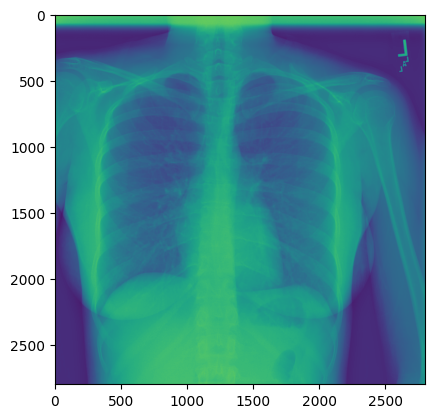

In [125]:
# example of non-nodule image is /data4/node21_dataset/cxr_images/original_data/images/c2203.mha
# load the file and show some slices
img_path = '/data4/node21_dataset/cxr_images/original_data/images/c2203.mha'
ds_A = sitk.ReadImage(img_path)
img_A = sitk.GetArrayFromImage(ds_A)
img_A = np.array(img_A, dtype=np.float32)
min, max = np.min(img_A), np.max(img_A)
img_A = ((img_A - min) / (max - min)) * 255
PIL_image_A = Image.fromarray(img_A.astype(np.uint8))
plt.imshow(PIL_image_A)
plt.show()

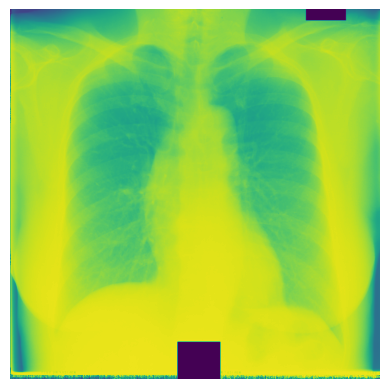

In [19]:
# example of nodule data is /data4/node21_dataset/cxr_images/original_data/images/n0719.mha
# load the file and show some slices
img_path = '/data4/node21_dataset/cxr_images/original_data/images/n0719.mha'
ds_A = sitk.ReadImage(img_path)
img_A = sitk.GetArrayFromImage(ds_A)
img_A = np.array(img_A, dtype=np.float32)
min, max = np.min(img_A), np.max(img_A)
img_A = ((img_A - min) / (max - min)) * 255
PIL_image_A = Image.fromarray(img_A.astype(np.uint8))
# plt.imshow(PIL_image_A, cmap='gray')
plt.imshow(PIL_image_A)
plt.axis('off')
plt.show()

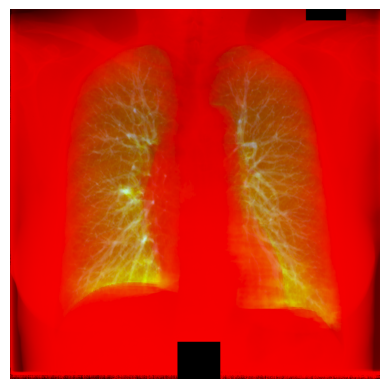

In [21]:
# visualize an example of test dataset
import matplotlib.pyplot as plt
import SimpleITK as sitk
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import nibabel as nib

img_path = '/data4/node21_dataset/cxr_images/original_data/images/n0719.mha'
ds_A = sitk.ReadImage(img_path)
img_A = sitk.GetArrayFromImage(ds_A)
img_A = np.array(img_A, dtype=np.float32)
min, max = np.min(img_A), np.max(img_A)
img_A = ((img_A - min) / (max - min)) * 255
PIL_image_A = Image.fromarray(img_A)


img_path = '/data4/tisepx_nodule/predict_lung/n0719.nii_fake_ori_0.nii'
ds_B = nib.load(img_path)
img_B = np.array(ds_B.get_fdata(), dtype=np.float32)
if len(img_B.shape) == 4:
    img_B = img_B[:,:,0,0]
else:
    min, max = np.min(img_B), np.max(img_B)
    img_B = ((img_B - min) / (max - min)) * 255
    # PIL_image_B = Image.fromarray(np.transpose(img_B).astype(np.uint8))
    PIL_image_B = Image.fromarray(np.transpose(img_B).astype(np.uint8))

img_path = '/data4/tisepx_nodule/predict_pulmonaryLung/n0719.nii_fake_0_fake_ori_0.nii'
ds_C = nib.load(img_path)
img_C = np.array(ds_C.get_fdata(), dtype=np.float32)
if len(img_C.shape) == 4:
    img_C = img_C[:,:,0,0]
else:
    min, max = np.min(img_C), np.max(img_C)
    img_C = ((img_C - min) / (max - min)) * 255
    PIL_image_C = Image.fromarray(np.transpose(img_C).astype(np.uint8))

# # concatenate 3 images
# result = Image.new("RGB", (PIL_image_A.width*3, PIL_image_A.height))
# result.paste(PIL_image_A, (0, 0))
# result.paste(PIL_image_B, (PIL_image_A.width, 0))
# result.paste(PIL_image_C, (PIL_image_A.width*2, 0))
# # result.save('/data4/concatenated.jpg')

# # show the concatenated image
# plt.imshow(result)

# # overlap 3 images
# img_A = np.array(PIL_image_A)
# img_B = np.array(PIL_image_B)
# img_C = np.array(PIL_image_C)

# img_A = img_A.astype(np.uint8)
# img_B = img_B.astype(np.uint8)
# img_C = img_C.astype(np.uint8)

# img_A = Image.fromarray(img_A)
# img_B = Image.fromarray(img_B)
# img_C = Image.fromarray(img_C)

# result = Image.new("RGB", (img_A.width, img_A.height))
# result.paste(img_A, (0, 0))
# result.paste(img_B, (0, 0),)
# result.paste(img_C, (0, 0), mask=img_C)
# plt.imshow(result)

# dstack 3 images
img_A = np.array(PIL_image_A)
img_B = np.array(PIL_image_B)
img_C = np.array(PIL_image_C)

img_A = img_A.astype(np.uint8)
img_B = img_B.astype(np.uint8)
img_C = img_C.astype(np.uint8)

img_A = Image.fromarray(img_A)
img_B = Image.fromarray(img_B)
img_C = Image.fromarray(img_C)

result = np.dstack((img_A, img_B, img_C))
# remove x, y axis
plt.axis('off')
plt.imshow(result)

x         1272
y         1505
width      176
height     176
Name: 1300, dtype: int64


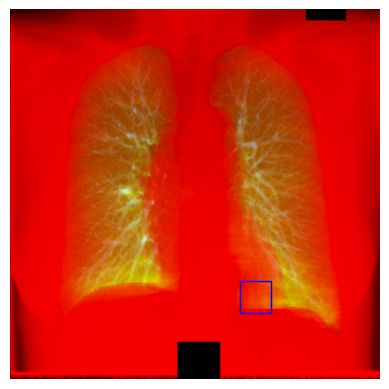

In [22]:
# using the coordinates, draw the bounding box
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd


coordinates = []
metadata_dir = '/data4/node21_dataset/cxr_images/original_data/metadata.csv'
df = pd.read_csv(metadata_dir)

i = 'n0719.mha'
coordinates.append(df.loc[df['img_name'] == i, ['x', 'y', 'width', 'height']].iloc[0])
print(coordinates[0])

# # find transpose of the coordinates
# coordinates[0][0], coordinates[0][1] = coordinates[0][1], coordinates[0][0]
# coordinates[0][2], coordinates[0][3] = coordinates[0][3], coordinates[0][2]


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(result)
ax.axis('off')

# Create a Rectangle patch
x = coordinates[0][0]
y = coordinates[0][1]
width = coordinates[0][2]
height = coordinates[0][3]
rect = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor='b',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

In [ ]:
from numba import cuda

device = cuda.get_current_device(); device.reset()